In [2]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# MCMC のサンプリング対象については
# 「正確な値が分からない => サンプリング対象」ということ
# 例えばコイントスの結果は面接者にとって未知であるから
# MCMC のサンプリング対象になるべき

# 今回の推定では
# 「面接結果 ans_true」から「カンニングの割合 p」を推定したい

N = 100

# 神の目線
p_true   = 0.35
ans_true = pm.rbernoulli(p_true, N)
print(ans_true)
print("%d/%d=%.3f" % (sum(ans_true), N, sum(ans_true)/N))


[ True False False  True  True False False False  True  True  True False
 False False False False False  True False  True False  True False False
 False False  True False False  True  True False  True  True False False
  True False  True False  True False False False False False False False
 False False False False  True  True False False False  True False False
 False False  True False False False False False False False False  True
  True  True False  True False  True  True  True False False  True False
  True False False False False  True False  True  True False  True False
  True False False False]
35/100=0.350


In [14]:
# p は未知なので一様分布
p = pm.Uniform("p", 0, 1)

# ans は p をもとに生成される
# この ans は「真実はこのように決定する」という
# モデルの一部であり，これが入力ではない
# ans を用意するのは
# ・真実というものが存在し，ベルヌーイ分布に従う
# ・真実は公開されず，obs_property を通して観測される
# という世界観のモデリングのため
ans = pm.Bernoulli("ans", p, size=N)

# プライバシーアルゴリズムに使用するコイントスの結果
# 実際には面接者に未知なので確率変数として扱い，
# MCMC でサンプリングする
flip_fst = pm.Bernoulli("flip_fst", 0.5, size=N)
flip_snd = pm.Bernoulli("flip_snd", 0.5, size=N)

# プライバシーアルゴリズムを考慮した
# 「カンニングしました」と回答する「確率」
@pm.deterministic
def obs_property(ff=flip_fst, fs=flip_snd, t=ans):
    observed = ff * t + (1-ff) * fs
    return observed.sum() / N

# このモデル化された世界で ans_true を生成してみる
# obs = pm.Binomial("obs", N, obs_property, value=sum(ans_true), observed=True)
# 本では上のように総和とって二項分布にしてたけど，系列のまま
# ベルヌーイ分布で推定したほうが話の流れ的に自然な気がしたのでそうした
obs = pm.Bernoulli("obs", obs_property, value=ans_true, observed=True)

model = pm.Model([p, ans, flip_fst, flip_snd, obs_property, obs])
mcmc  = pm.MCMC(model)
mcmc.sample(40000, 15000)

 [-----------------100%-----------------] 40000 of 40000 complete in 24.1 sec

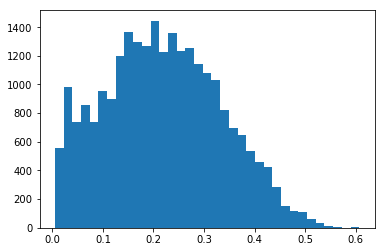

In [15]:
plt.hist(mcmc.trace("p")[:], bins=35)
plt.show()

# ベルヌーイ分布でやった結果，二項分布よりも不確定性が大きいように見える
# 関心があるのは「誰が」ではなくカンニングの割合事態なので，
# 総和をとってしまった方が余計が情報が削減出来て正確になるということかも
#
# 「まだまだ不確定」というのは本でも触れられている通りなので問題なし